# Emotion Classification in texts using Bi-LSTM and FastText

### Architecture: 
(X) Text -> Embedding (W2V pretrained on wikipedia articles) -> Deep Network (Bi-LSTM) -> Fully connected (Dense) -> Output Layer (Softmax) -> Emotion class (Y)

#### Embedding Layer
* Word Embedding is a representation of text where words that have the similar meaning have a similar representation. We will use 300 dimentional word vectors pre-trained on wikipedia articles. 

#### Fully Connected Layer
* To be explained about Bi-LSTM in sentiment / emotion analysis

#### Output Layer
* This layer uses have either Sigmoid for binary classification or Softmax for both binary and multi classification output.

## Workflow: 
1. Import Data
2. Prepare the input data
3. Import pre-trained FastText
4. Create Neural Network Pipeline
5. Train The Model
6. Evaluate results

## 1. Import Data

In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

#Visualization
import seaborn as sns

Defining vector space dimension and fixed input size

In [2]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

Importing our training and testing datasets

In [5]:
data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
print(data.Emotion.value_counts())
data.head(6)

joy        2349
sadness    2302
anger      2266
neutral    2258
fear       2152
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


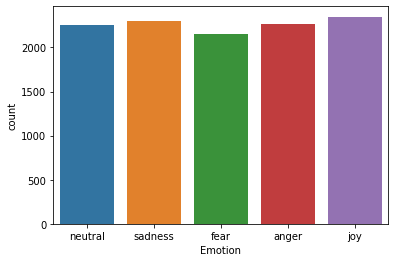

In [7]:
sns.countplot(data=data, x = 'Emotion')

## 2. Prepare input data
To input the data to our CNN Model we'll need some preprocessing:
1. Tokenize our texts and count unique tokens
2. Padding: each input (sentence or text) has to be of the same lenght
3. Labels have to be converted to integeres and categorized

In [8]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [11]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


**Tokenization + fitting using keras**

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 11859


**Padding** -> each input has the same length

In [13]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,  114,   51,  342],
       [   0,    0,    0, ...,   38,  277,  155],
       [   0,    0,    0, ...,   16,    2, 1217],
       ...,
       [   0,    0,    0, ...,  869,    4,  897],
       [   0,    0,    0, ...,    1,    6,  116],
       [   0,    0,    0, ..., 5867,  174,   13]], dtype=int32)

**Categorize** labels:

In [14]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [15]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors.

* Importing pretrained word2vec from file and creating embedding matrix
* We will later map each word in our corpus to existing word vector

In [16]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [17]:
import urllib.request
import zipfile
import os

fname = '/content/drive/MyDrive/Aznida_CNN/Word2Vec_FastText/wiki-news-300d-1M.vec'

In [18]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(11860, 300)

In [19]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11235
New words found: 624


## 3. Create Bi-LSTM Pipeline

### Embedding Layer

We will use pre-trained word vectors. We could also train our own embedding layer if we don't specify the pre-trained weights 

* **vocabulary size:** the maximum number of terms that are used to represent a text: e.g. if we set the size of the “vocabulary” to 1000 only the first thousand terms most frequent in the corpus will be considered (and the other terms will be ignored)
* **the maximum length:** of the texts (which must all be the same length)
* **size of embeddings:** basically, the more dimensions we have the more precise the semantics will be, but beyond a certain threshold we will lose the ability of the embedding to define a coherent and general enough semantic area
* **trainable:** True if you want to fine-tune them while training

In [20]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

### Model Pipeline
- the input is the first N words of each text (with proper padding)
- the first level creates embedding of words, using vocabulary with a certain dimension, and a given size of embeddings
- LSTM/GRU layer which will receive word embeddings for each token in the tweet as inputs. The intuition is that its output tokens will store information not only of the initial token, but also any previous tokens; In other words, the LSTM layer is generating a new encoding for the original input.
- the output level has a number of neurons equal to the classes of the problem and a “softmax” activation function

In [21]:
# Parameters
lstm_output_size = 128

# Embedding Layer, biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)
model.add(Bidirectional(LSTM(units=lstm_output_size, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(num_classes, activation='softmax'))

In [22]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3558000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 3,998,581
Trainable params: 440,581
Non-trainable params: 3,558,000
_________________________________________________________________


### 3. Train the Model

We will use pre-trained word vectors. We could also train our own embedding layer if we don't specify the pre-trained weights 

* **validation data:** use validation_split in order to estimate how well your model has been trained and adjust parameters or add dropout layers. After that we will train the model using the complete train set.
* **epoch:** 15 batch_size: 128

In [23]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
62/62 [==============================] - 546s 9s/step - loss: 1.5058 - accuracy: 0.3040 - val_loss: 1.2015 - val_accuracy: 0.5426
Epoch 2/15
62/62 [==============================] - 537s 9s/step - loss: 1.1218 - accuracy: 0.5617 - val_loss: 0.9803 - val_accuracy: 0.6351
Epoch 3/15
62/62 [==============================] - 542s 9s/step - loss: 0.9076 - accuracy: 0.6668 - val_loss: 0.8899 - val_accuracy: 0.6746
Epoch 4/15
62/62 [==============================] - 544s 9s/step - loss: 0.8531 - accuracy: 0.6901 - val_loss: 0.8835 - val_accuracy: 0.6788
Epoch 5/15
62/62 [==============================] - 541s 9s/step - loss: 0.7895 - accuracy: 0.7110 - val_loss: 0.8146 - val_accuracy: 0.6970
Epoch 6/15
62/62 [==============================] - 545s 9s/step - loss: 0.7742 - accuracy: 0.7167 - val_loss: 0.8091 - val_accuracy: 0.7059
Epoch 7/15
62/62 [==============================] - 534s 9s/step - loss: 0.7283 - accuracy: 0.7336 - val_loss: 0.7800 - val_accuracy: 0.7144
Epoch 8/15
62

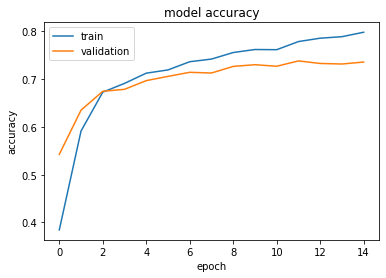

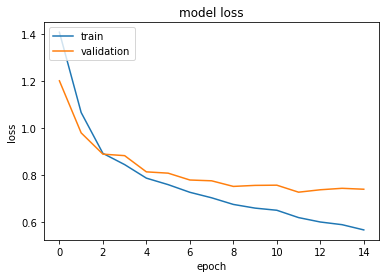

In [24]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Evaluation

In [25]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [26]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 73.59%

F1 Score: 73.59


In [27]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [28]:
import time

message = ['I have so many negative thoughts in my mind']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['I have so many negative thoughts in my mind']
predicted: sadness (0.25 seconds)
